# Lane Detection from Image

<b>Import Libraries</b>

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

<b>Import Colored Image</b>

In [2]:
image = cv.imread('Road.png')
cv.imshow("Road Image",image)
cv.waitKey(0)
cv.destroyAllWindows()

<b>Image Processing</b>

In [3]:
def gradient(image):
    gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)  # Convert to Grayscale
    smooth_image = cv.GaussianBlur(gray_image,(5,5),0)  # Gaussian Blur (Smoothening)
    gradient_image = cv.Canny(smooth_image,50,150)      # Canny Edge Detection (Gradients)
    return gradient_image

In [4]:
gradient_image = gradient(image)
cv.imshow("Gradient Image",gradient_image)
cv.waitKey(0)
cv.destroyAllWindows()

<b>Region of Interest</b>

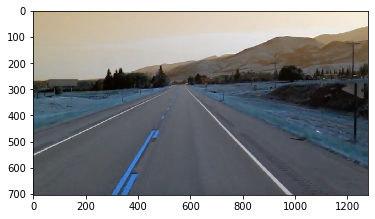

In [5]:
plt.imshow(image)

In [6]:
def region_of_interest(image):
    ROI = np.array([[(200,700),(1100,700),(550,250)]]) #Defining Triangular ROI (Refer Above Image)
    mask = np.zeros_like(image) # Create Mask (Black Image) of Same Dimension as Image
    cv.fillPoly(mask,ROI,255) # Fill Mask with White ROI
    masked_image = cv.bitwise_and(mask,image) # Bitwise AND Source Image and Mask to Obtain Masked Image
    return masked_image

In [7]:
ROI = region_of_interest(gradient_image)
cv.imshow("Region of Interest",ROI)
cv.waitKey(0)
cv.destroyAllWindows()

<b>Lane Detection from Gradient Image (Line Detection using Hough Transform)</b>

In [8]:
# Parameters (Arguments):
# Image for Line Detection = Region of Interest Image
# Rho Accuracy = 2 Pixel
# Theta Accuracy = pi/180 = (1 Degree)
# Threshold (Minimum Number of Votes to Consider a Line) = 100
# Placeholder Argument = Empty Array
# Threshold Length of Detected Line = 40 Pixels
# Maximum Distance between 2 Lines to Consider them as a Single Line = 5 Pixels
lines = cv.HoughLinesP(ROI,2,np.pi/180,100,np.array([]),40,5) # Returns Lines as 2D Arrays of Points
print(lines)

[[[704 418 927 641]]

 [[704 426 807 533]]

 [[322 700 445 494]]

 [[820 547 877 608]]

 [[660 379 710 431]]

 [[588 299 660 371]]

 [[638 356 681 399]]

 [[863 592 903 634]]

 [[403 541 433 495]]

 [[592 304 648 360]]

 [[747 472 802 529]]

 [[853 568 898 613]]]


In [9]:
def display_detected_lines(image,lines):
    line_image = np.zeros_like(image) #Black Image
    if lines is not None:
        for line in lines:
            x1,y1,x2,y2 = line.reshape(4) # 2D Array [[x1 y1 x2 y2]] --> 1D Array of 4 Elements [x1 y1 x2 y2]
            cv.line(line_image,(x1,y1),(x2,y2),[0,255,0],10) #Arguments: Image, First Point Coordinate to Draw Line, Second Point Coordinate to Draw Line, Color of the Line [BGR], Line Thickness
    lanes_detected_image = cv.addWeighted(image,0.8,line_image,1,0) #Arguments: Image Array 1, Weight 1, Image Array 2 (Same Size as Image Array 1), Weight 2, Gamma = Scalar Added to Each Sum
    return(lanes_detected_image)

In [10]:
lanes_detected_image = display_detected_lines(image,lines)
cv.imshow("Road Image with Detected Lanes",lanes_detected_image)
cv.waitKey(0)
cv.destroyAllWindows()

<b>Optimization</b>

In [11]:
def make_coordinates(image,line_parameters):
    slope,intercept = line_parameters
    y1 = image.shape[0] # Initial Y-Coordinate to Draw Lines
    y2 = int(y1*(3/5)) # Final Y-Coordinate to Draw Lines
    x1 = int((y1-intercept)/slope) # y=mx+c ==> x=(y-c)/m
    x2 = int((y2-intercept)/slope) # y=mx+c ==> x=(y-c)/m
    coordinates = np.array([x1,y1,x2,y2])
    return(coordinates)

In [12]:
def average_slope_intercept(image,lines):
    left_fit = [] # This List will Contain Coordinates of Left Lane Line
    right_fit = [] # # This List will Contain Coordinates of Right Lane Line
    for line in lines:
        x1,y1,x2,y2 = line.reshape(4) # 2D Array [[x1 y1 x2 y2]] --> 1D Array of 4 Elements [x1 y1 x2 y2]
        parameters = np.polyfit((x1,x2),(y1,y2),1) # Fits a Polynomial of Degree 1 (Last Argument) to Given Pair of Points (x1,x2),(y1,y2) and Returns the Vector Containing Slope and Y-Intercept
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:                          # Deciding Lines Based on Slope (-ve-->Left & +ve-->Right)
            left_fit.append((slope,intercept))
        else:
            right_fit.append((slope,intercept))
    left_fit_average = np.average(left_fit,axis=0) # Average Left Line Array Vertically (Axis=0) to get Average Slopes and Intercepts
    right_fit_average = np.average(right_fit,axis=0) # Average Right Line Array Vertically (Axis=0) to get Average Slopes and Intercepts
    left_line = make_coordinates(image,left_fit_average) # Draw Left Line Based on Coordinates, Slope and Intercept
    right_line = make_coordinates(image,right_fit_average) # Draw Right Line Based on Coordinates, Slope and Intercept
    averaged_lines = np.array([left_line,right_line])
    return(averaged_lines)

In [13]:
averaged_lines = average_slope_intercept(image,lines)

In [14]:
lanes_detected_image = display_detected_lines(image,averaged_lines)
cv.imshow("Optimized Road Image with Detected Lanes",lanes_detected_image)
cv.waitKey(0)
cv.destroyAllWindows()